In [1]:
from utils import *
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import pickle as pkl

from tqdm.notebook import tqdm
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

USE_CACHE=True

In [2]:
# Blue to red color scheme
color_rgbs = [
    [178,24,43],
    [239,138,98],
    [253,219,199],
    [33,102,172]
]

color_rgbs = [list((c / 256 for c in l)) for l in color_rgbs][::-1]
custom_map = ListedColormap(color_rgbs, name="custom")

#### Only run the following cell if you don't want to use the cached values and instead want to re-run the calculations.

In [3]:
params = {}

SIZE = int(1e3)

g = 9.8 # gravity
params["dl"] = 1 # height lower
params["mu_l"] = 1e3 # visc lower
params["rho_l"] = 3000 # density lower
params["rho_u"] = 2970 # density upper
params["r"] = params["rho_l"] / params["rho_u"] # density ratio


dls = np.concatenate([np.linspace(.2, 1, SIZE // 2), np.linspace(1.01, 5, SIZE // 2)])[::-1]

Kls = np.logspace(2, 6, SIZE)

Ups = Kls * (params["dl"] ** 2) / params["mu_l"]

Fs = np.sqrt((params["rho_l"]-params["rho_u"]) / \
                          params["rho_u"] * g * params["dl"] / (Ups ** 2))


d2d2, ff = np.meshgrid(dls, Fs)

zs = []
# for viscosity range
for idx, m in enumerate([.33, .2, .1]):
    params["m"] = m
    params["mu_u"] = params["mu_l"] / m
    
    z = np.zeros((len(dls), len(Fs))).T
    # for k range
    for y_idx, (Kl_p, U_p, F) in enumerate(tqdm(zip(Kls, Ups, Fs), total=SIZE)):
        params["Kl_p"] = Kl_p
        params["U_p"] = U_p
        params["F"] = F
        
        # for height range
        for x_idx, n in enumerate(dls):
                        
            params["du"] = params["dl"] / n
            params["n"] = n
            params["Ku_p"] = params["Kl_p"]

            J = no_slip_J(**params)
            z[y_idx, x_idx] += int(J > 0)
    zs.append(z)
    
if not os.path.exists("cached_matrices"):
    os.mkdir("cached_matrices")
    
pkl.dump(zs, open("cached_matrices/zs.pkl", "wb"))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
if USE_CACHE and os.path.exists("cached_matrices"):
    try:
        d2d2 = np.load("cached_matrices/no_slip_d2d2.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Run the previous cell or pull from the github repo to get d2d2 data.")
        
    try:
        ff = np.load("cached_matrices/no_slip_ff.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Run the previous cell or pull from the github repo to get ff data.")
        
    try:
        z = np.load("cached_matrices/no_slip_z.npy", allow_pickle=True)
    except FileNotFoundError:
        print("Run the previous cell or pull from the github repo to get z data.")

Run the previous cell or pull from the github repo to get d2d2 data.
Run the previous cell or pull from the github repo to get ff data.
Run the previous cell or pull from the github repo to get z data.


In [5]:
# mask each stability simulation for clean graphing
red = zs[0] * 3
orange = zs[1] * 2
orange[np.where(red > 0)] = 0
yellow = zs[2]
yellow[np.where((red > 0) | (orange > 0))] = 0

combo_z = red + orange + yellow

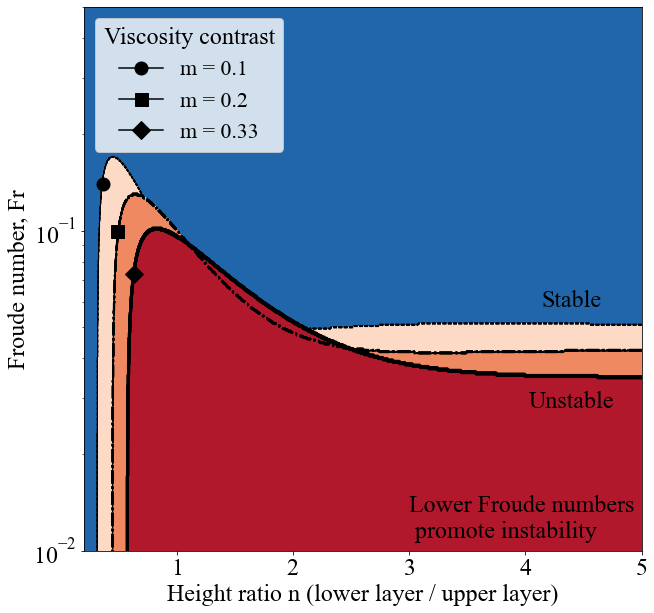

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(d2d2, ff, combo_z, cmap=custom_map)

LW = 3
a1 = ax.contour(d2d2, ff, zs[0], colors="black", linestyles="-", linewidths=LW)
a2 = ax.contour(d2d2, ff, zs[1], colors="black", linestyles="-.", linewidths=LW - 1)
a3 = ax.contour(d2d2, ff, zs[2], colors="black", linestyles="--", linewidths=LW - 2)

MARKER_SIZE = 13

m1_line = mlines.Line2D([], [], color='black', label='m = 0.1', marker="o", markersize=MARKER_SIZE)
m2_line = mlines.Line2D([], [], color='black', label='m = 0.2', marker="s", markersize=MARKER_SIZE)
m3_line = mlines.Line2D([], [], color='black', label='m = 0.33', marker="D", markersize=MARKER_SIZE)

ax.plot(.37, .14, 'o', markersize=MARKER_SIZE, color="black")
ax.plot(.49, .1, 's', markersize=MARKER_SIZE, color="black")
ax.plot(.63, .073, 'D', markersize=MARKER_SIZE, color="black")


ax.text(4.4, .028, "Unstable", c="black", ha="center")
ax.text(4.4, .058, "Stable", c="black", ha="center")
ax.text(3, .011, "Lower Froude numbers\n promote instability", c="black")

ax.set_ylabel("Froude number, Fr")
ax.set_xlabel("Height ratio n (lower layer / upper layer)")

plt.legend(handles=[m1_line, m2_line, m3_line], \
           loc="upper left", fontsize=22, title="Viscosity contrast")

ax.set_yscale('log')
ax.set_ylim(1e-2, .5)

if not os.path.exists("paper_figures"):
    os.mkdir("paper_figures")

fig.savefig("paper_figures/no_slip_phase.png")
fig.savefig("paper_figures/no_slip_phase.svg", format="svg")

In [7]:
if not os.path.exists("cached_matrices"):
    os.mkdir("cached_matrices")
    
np.save("cached_matrices/no_slip_d2d2.npy", d2d2)
np.save("cached_matrices/no_slip_ff.npy", ff)
np.save("cached_matrices/no_slip_z.npy", z)